In [1]:
!pip install git+https://gitlab-research.centralesupelec.fr/stergios.christodoulidis/text-flappy-bird-gym


  Cloning https://gitlab-research.centralesupelec.fr/stergios.christodoulidis/text-flappy-bird-gym to c:\users\eloua\appdata\local\temp\pip-req-build-d5szc1mq
  Resolved https://gitlab-research.centralesupelec.fr/stergios.christodoulidis/text-flappy-bird-gym to commit ca2797e9270195313423324c9d0f205f6cbb3d28
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
   ---------------------------------------- 0.0/953.8 kB ? eta -:--:--
   - ------------------------------------- 30.7/953.8 kB 640.0 kB/s eta 0:00:02
   - ------------------------------------- 30.7/953.8 kB 640.0 kB/s eta 0:00:02
   -- ------------------------------------ 61.4/953.8 kB 409.6 kB/s eta 0:00:03
   ---- --------------------------------- 122.9/953.8 kB 654.9 kB/s eta 0:00:02
   --------- ------------------------------ 225.3/953.8 kB 1.1 MB/s eta 0:00:01
   ----------- ---------------------------- 266.2/953.8 kB 1.1 MB/s eta 0:00:01
   ------------ ---------------------

  Running command git clone --filter=blob:none --quiet https://gitlab-research.centralesupelec.fr/stergios.christodoulidis/text-flappy-bird-gym 'C:\Users\eloua\AppData\Local\Temp\pip-req-build-d5szc1mq'


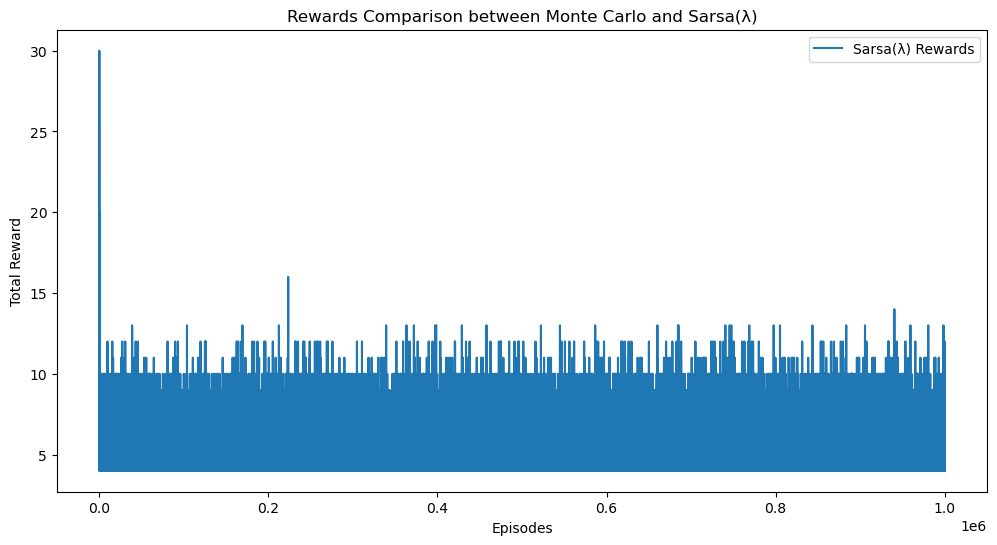

In [9]:
import numpy as np
from collections import defaultdict
import json
import numpy as np
from collections import defaultdict
import matplotlib.pyplot as plt

import gymnasium as gym
import text_flappy_bird_gym

def serialize(state):
    """ Serialize the state dictionary to a string to use as a dictionary key. """
    return json.dumps(state, sort_keys=True)

def make_epsilon_greedy_policy(Q, epsilon, nA):
    """ Creates an epsilon-greedy policy based on a given Q-function and epsilon. """
    def policy_fn(observation):
        observation_str = serialize(observation)  # Convert dict observation to string
        A = np.ones(nA, dtype=float) * epsilon / nA
        best_action = np.argmax(Q[observation_str])
        A[best_action] += (1.0 - epsilon)
        return A
    return policy_fn


def monte_carlo_control(env, num_episodes, discount_factor=1.0, epsilon_start=1.0, epsilon_min=0.1, epsilon_decay=0.99):
    Q = defaultdict(lambda: np.zeros(env.action_space.n))
    returns_sum = defaultdict(float)
    returns_count = defaultdict(float)
    rewards_mc = []
    epsilon = epsilon_start  # Initialize epsilon

    for i_episode in range(num_episodes):
        episode = []
        total_reward = 0
        state = env.reset()
        state = serialize(state)  # Serialize the initial state
        while True:
            action_probs = make_epsilon_greedy_policy(Q, epsilon, env.action_space.n)(state)
            action = np.random.choice(np.arange(len(action_probs)), p=action_probs)
            next_state, reward, done, truncated, _ = env.step(action)
            next_state = serialize(next_state)  # Serialize the next state
            episode.append((state, action, reward))
            total_reward += reward
            if done:
                break
            state = next_state
        rewards_mc.append(total_reward)
        for state, action, reward in episode:
            returns_sum[(state, action)] += reward
            returns_count[(state, action)] += 1
            Q[state][action] = returns_sum[(state, action)] / returns_count[(state, action)]
        
        epsilon = max(epsilon_min, epsilon * epsilon_decay)  # Decay epsilon

    policy = make_epsilon_greedy_policy(Q, epsilon, env.action_space.n)
    return Q, policy, rewards_mc


def sarsa_lambda(env, num_episodes, discount_factor=1.0, alpha=0.5, initial_epsilon=1.0, min_epsilon=0.1, epsilon_decay=0.995, lambda_=0.9):
    """
    Sarsa(λ) algorithm with epsilon decay over episodes.
    
    :param env: OpenAI Gym environment
    :param num_episodes: total number of episodes to run
    :param discount_factor: gamma discount factor for future rewards
    :param alpha: step size (learning rate)
    :param initial_epsilon: starting epsilon for epsilon-greedy policy
    :param min_epsilon: minimum value that epsilon can decay to
    :param epsilon_decay: decay rate of epsilon per episode
    :param lambda_: trace decay parameter
    :return: Q (action-value function dictionary), policy function, and episode rewards list
    """
    Q = defaultdict(lambda: np.zeros(env.action_space.n))
    rewards_sarsa = []  # List to store rewards for each episode
    epsilon = initial_epsilon  

    for i_episode in range(num_episodes):
        total_reward = 0
        state = env.reset()
        state = serialize(state)
        policy = make_epsilon_greedy_policy(Q, epsilon, env.action_space.n)
        action_probs = policy(state)
        action = np.random.choice(np.arange(len(action_probs)), p=action_probs)

        while True:
            next_state, reward, done, truncated, _ = env.step(action)
            next_state = serialize(next_state)
            total_reward += reward
            next_action_probs = policy(next_state)
            next_action = np.random.choice(np.arange(len(next_action_probs)), p=next_action_probs)
            delta = reward + discount_factor * Q[next_state][next_action] - Q[state][action]
            Q[state][action] += alpha * delta
            if done:
                break
            state = next_state
            action = next_action

        rewards_sarsa.append(total_reward)
        
        # Epsilon decay
        epsilon = max(min_epsilon, epsilon * epsilon_decay)

    policy = make_epsilon_greedy_policy(Q, epsilon, env.action_space.n)
    return Q, policy, rewards_sarsa



env = gym.make('TextFlappyBird-v0', height=15, width=20, pipe_gap=4)

# Monte Carlo 
Q_mc, policy_mc, rewards_mc = monte_carlo_control(env, num_episodes=1000000, discount_factor=0.99, epsilon_start=1.0, epsilon_min=0.1, epsilon_decay=0.99)

# Sarsa(λ) 
Q_sarsa, policy_sarsa, rewards_sarsa = sarsa_lambda(env, num_episodes=1000000, discount_factor=0.99, alpha=0.5, initial_epsilon=1.0, min_epsilon=0.1, epsilon_decay=0.995, lambda_=0.9)
plt.figure(figsize=(12, 6))
#plt.plot(rewards_mc, label='Monte Carlo Rewards')
plt.plot(rewards_sarsa, label='Sarsa(λ) Rewards')
plt.xlabel('Episodes')
plt.ylabel('Total Reward')
plt.title('Rewards Comparison between Monte Carlo and Sarsa(λ)')
plt.legend()
plt.show()


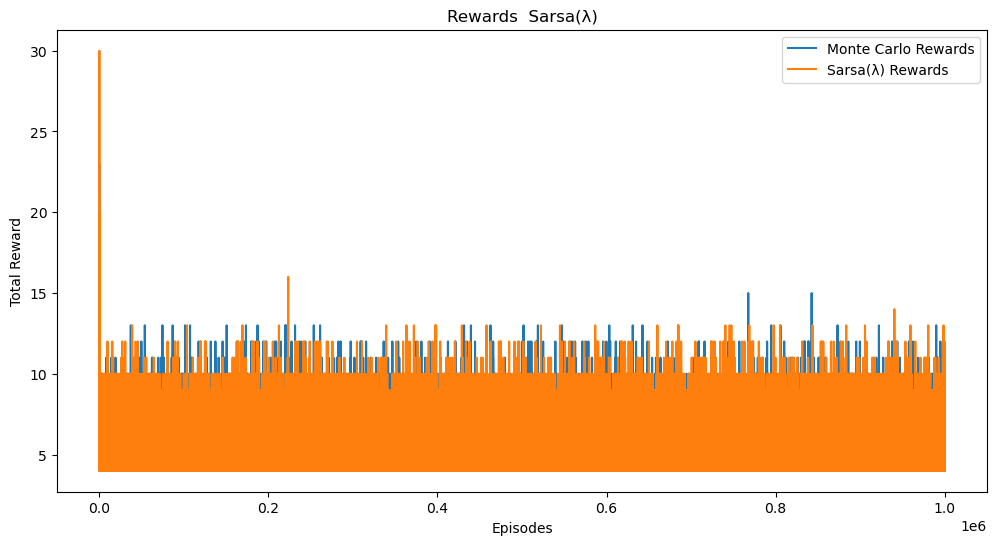

In [10]:
plt.figure(figsize=(12, 6))
plt.plot(rewards_mc, label='Monte Carlo Rewards')
plt.plot(rewards_sarsa, label='Sarsa(λ) Rewards')
plt.xlabel('Episodes')
plt.ylabel('Total Reward')
plt.title('Rewards  Sarsa(λ)')
plt.legend()
plt.show()


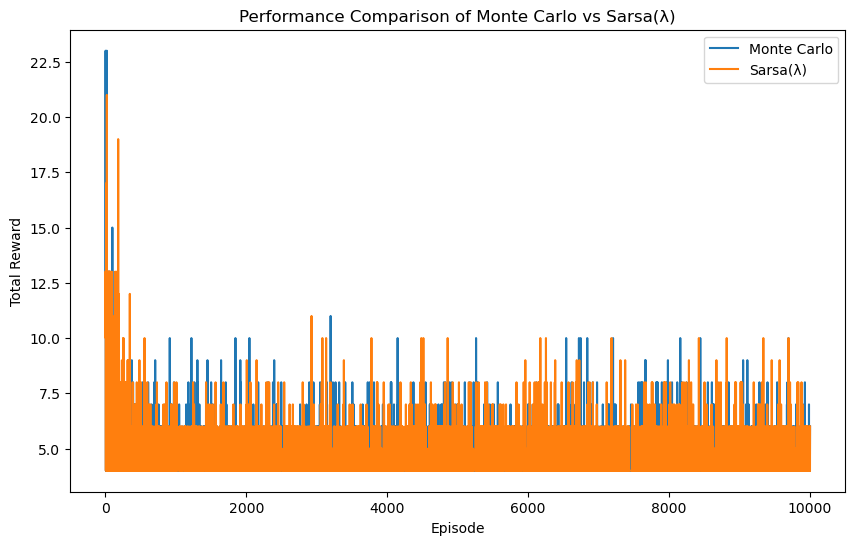

In [36]:
import matplotlib.pyplot as plt

# Assuming rewards_mc and rewards_sarsa are lists of rewards per episode
episodes = range(1, len(rewards_mc) + 1)
plt.figure(figsize=(10, 6))
plt.plot(episodes, rewards_mc, label='Monte Carlo')
plt.plot(episodes, rewards_sarsa, label='Sarsa(λ)')
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.title('Performance Comparison of Monte Carlo vs Sarsa(λ)')
plt.legend()
plt.show()


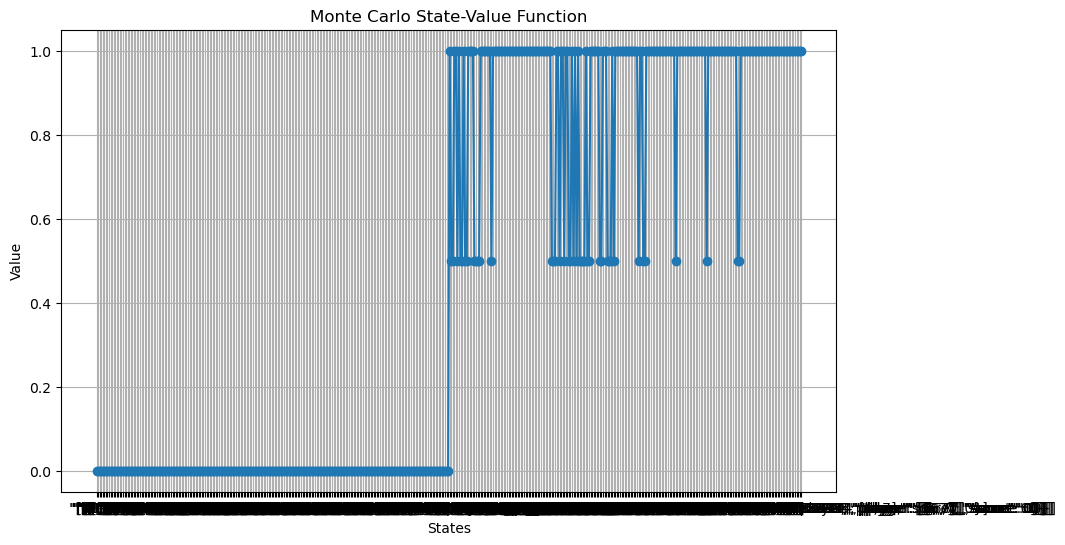

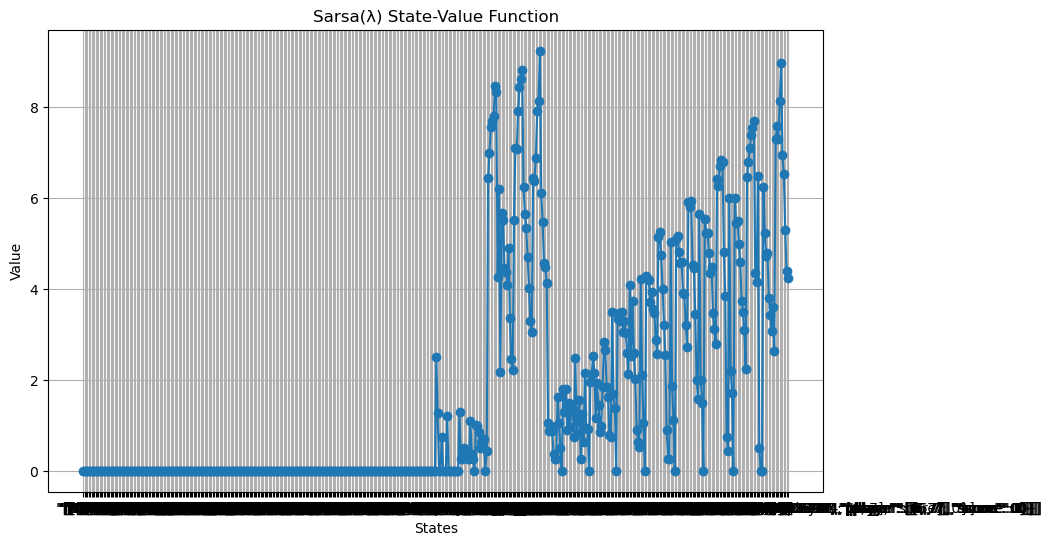

In [11]:
import matplotlib.pyplot as plt
import numpy as np

def plot_state_values(Q, title='State-Value Function'):
    """ Plot the state-value function from Q-values """
    # Extract state values by averaging over Q-values for all possible actions
    state_values = {state: np.mean(actions) for state, actions in Q.items()}
    states, values = zip(*sorted(state_values.items()))
    
    plt.figure(figsize=(10, 6))
    plt.plot(states, values, marker='o')
    plt.title(title)
    plt.xlabel('States')
    plt.ylabel('Value')
    plt.grid(True)
    plt.show()

# Example usage for Monte Carlo and Sarsa(λ)
plot_state_values(Q_mc, title='Monte Carlo State-Value Function')
plot_state_values(Q_sarsa, title='Sarsa(λ) State-Value Function')


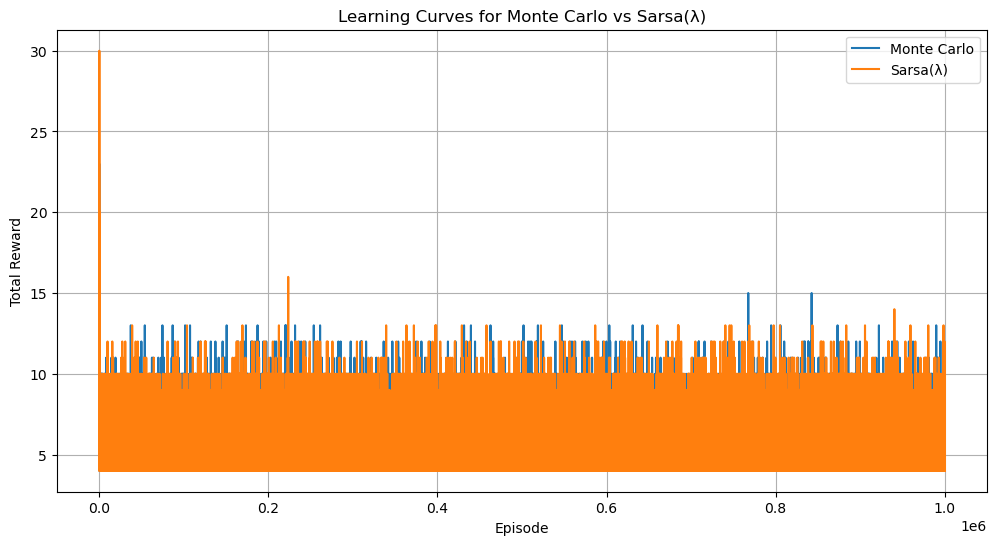

In [12]:
def plot_learning_curves(rewards_mc, rewards_sarsa):
    episodes = np.arange(1, len(rewards_mc) + 1)
    plt.figure(figsize=(12, 6))
    plt.plot(episodes, rewards_mc, label='Monte Carlo')
    plt.plot(episodes, rewards_sarsa, label='Sarsa(λ)')
    plt.xlabel('Episode')
    plt.ylabel('Total Reward')
    plt.title('Learning Curves for Monte Carlo vs Sarsa(λ)')
    plt.legend()
    plt.grid(True)
    plt.show()

plot_learning_curves(rewards_mc, rewards_sarsa)


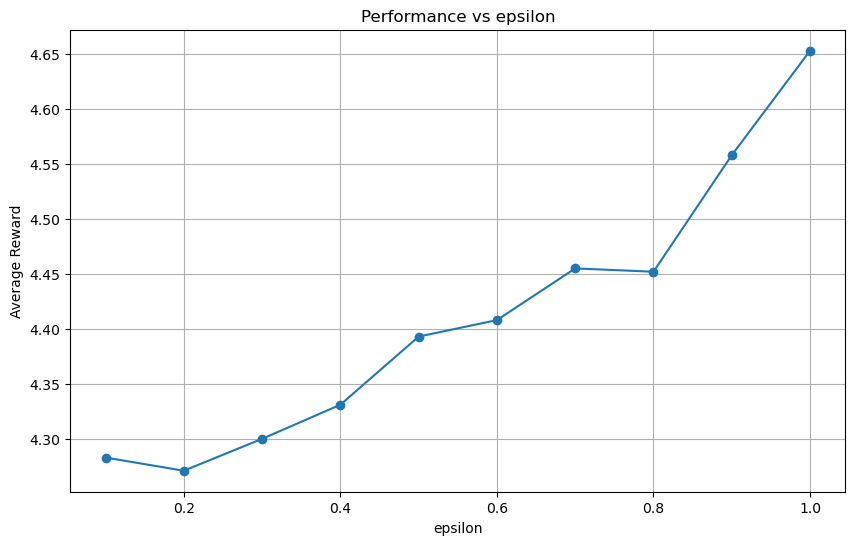

In [13]:
def parameter_sweep(env, num_episodes, param_values, param_name='epsilon'):
    results = []
    for value in param_values:
        if param_name == 'epsilon':
            _, _, rewards = monte_carlo_control(env, num_episodes, epsilon_start=value)
        elif param_name == 'alpha':
            _, _, rewards = sarsa_lambda(env, num_episodes, alpha=value)
        
        results.append(np.mean(rewards))
    
    plt.figure(figsize=(10, 6))
    plt.plot(param_values, results, marker='o')
    plt.title(f'Performance vs {param_name}')
    plt.xlabel(param_name)
    plt.ylabel('Average Reward')
    plt.grid(True)
    plt.show()


epsilons = np.linspace(0.1, 1.0, 10)
parameter_sweep(env, 1000, epsilons, param_name='epsilon')


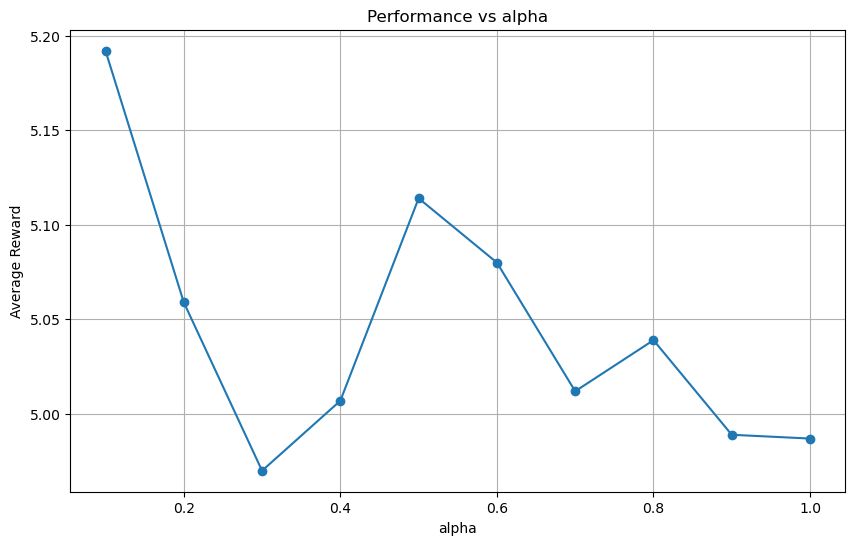

In [17]:
def parameter_sweep(env, num_episodes, param_values, param_name='epsilon'):
    results = []
    for value in param_values:
        if param_name == 'epsilon':
            _, _, rewards = monte_carlo_control(env, num_episodes, epsilon_start=value)
        elif param_name == 'alpha':
            _, _, rewards = sarsa_lambda(env, num_episodes, alpha=value)
    
        results.append(np.mean(rewards))
    
    plt.figure(figsize=(10, 6))
    plt.plot(param_values, results, marker='o')
    plt.title(f'Performance vs {param_name}')
    plt.xlabel(param_name)
    plt.ylabel('Average Reward')
    plt.grid(True)
    plt.show()


epsilons = np.linspace(0.1, 1.0, 10)
parameter_sweep(env, 1000, epsilons, param_name='alpha')

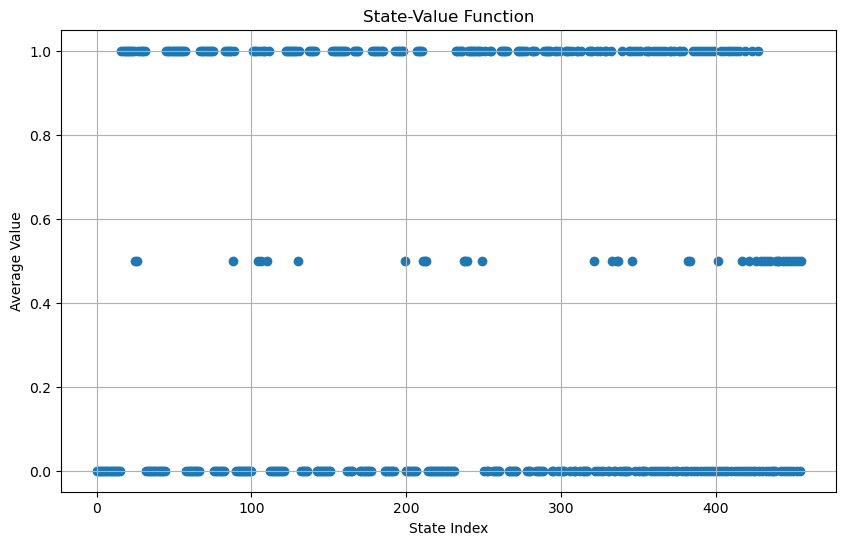

In [15]:
import matplotlib.pyplot as plt
import numpy as np


def plot_state_value(Q):
    
    states = list(Q.keys())
    values = [np.mean(Q[state]) for state in states]
    
    plt.figure(figsize=(10, 6))
    plt.scatter(range(len(states)), values)
    plt.title('State-Value Function')
    plt.xlabel('State Index')
    plt.ylabel('Average Value')
    plt.grid(True)
    plt.show()

plot_state_value(Q_mc)  


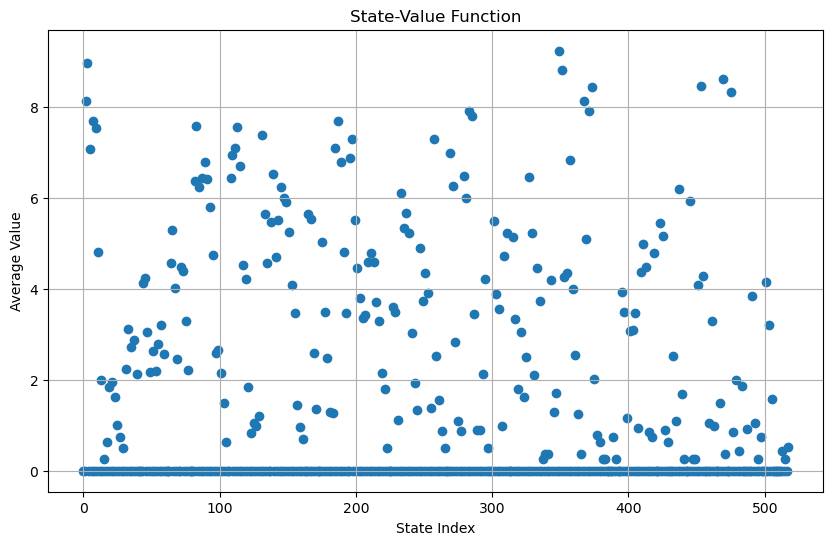

In [16]:
import matplotlib.pyplot as plt
import numpy as np


def plot_state_value(Q):
    
    states = list(Q.keys())
    values = [np.mean(Q[state]) for state in states]
    
    plt.figure(figsize=(10, 6))
    plt.scatter(range(len(states)), values)
    plt.title('State-Value Function')
    plt.xlabel('State Index')
    plt.ylabel('Average Value')
    plt.grid(True)
    plt.show()

plot_state_value(Q_sarsa) 


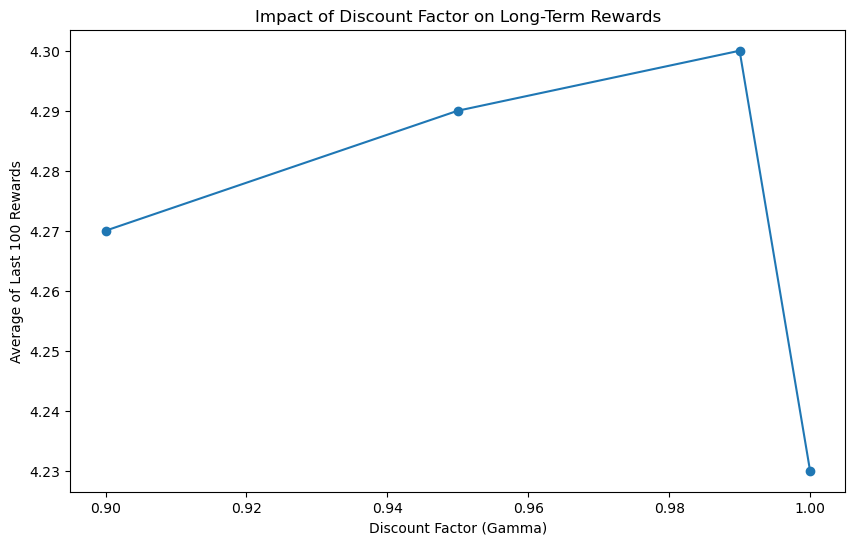

In [20]:
gammas = [0.9, 0.95, 0.99, 1.0]  # Different values of gamma to test
results_gamma = {}

for gamma in gammas:
    Q, policy, rewards = monte_carlo_control(env, num_episodes=100000, discount_factor=gamma)
    results_gamma[gamma] = np.mean(rewards[-100:])  # Average the last 100 episodes for long-term rewards

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(list(results_gamma.keys()), list(results_gamma.values()), marker='o')
plt.xlabel('Discount Factor (Gamma)')
plt.ylabel('Average of Last 100 Rewards')
plt.title('Impact of Discount Factor on Long-Term Rewards')
plt.show()


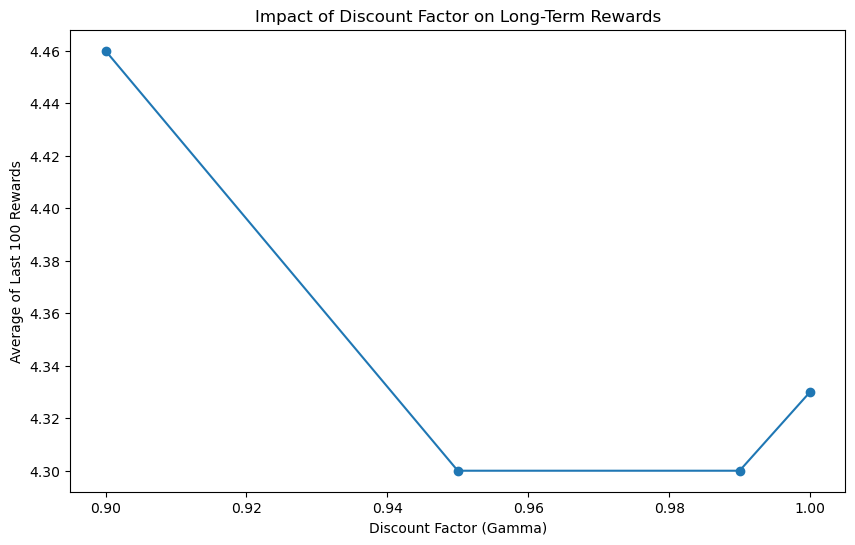

In [21]:
gammas = [0.9, 0.95, 0.99, 1.0]  # Different values of gamma to test
results_gamma = {}

for gamma in gammas:
    Q, policy, rewards = sarsa_lambda(env, num_episodes=100000, discount_factor=gamma)
    results_gamma[gamma] = np.mean(rewards[-100:])  # Average the last 100 episodes for long-term rewards

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(list(results_gamma.keys()), list(results_gamma.values()), marker='o')
plt.xlabel('Discount Factor (Gamma)')
plt.ylabel('Average of Last 100 Rewards')
plt.title('Impact of Discount Factor on Long-Term Rewards')
plt.show()


In [70]:
# Monte carlo with the optimal hyperparametres
Q_mc, policy_mc, rewards_mc = monte_carlo_control(env, num_episodes=10000, discount_factor=0.99, epsilon_start=1.0, epsilon_min=0.1, epsilon_decay=0.99)

# Sarsa(λ) with the optimal hyperparametres
Q_sarsa, policy_sarsa, rewards_sarsa = sarsa_lambda(env, num_episodes=10000, discount_factor=0.9, alpha=0.8, initial_epsilon=0.1, min_epsilon=0.1, epsilon_decay=0.995, lambda_= 0.9)

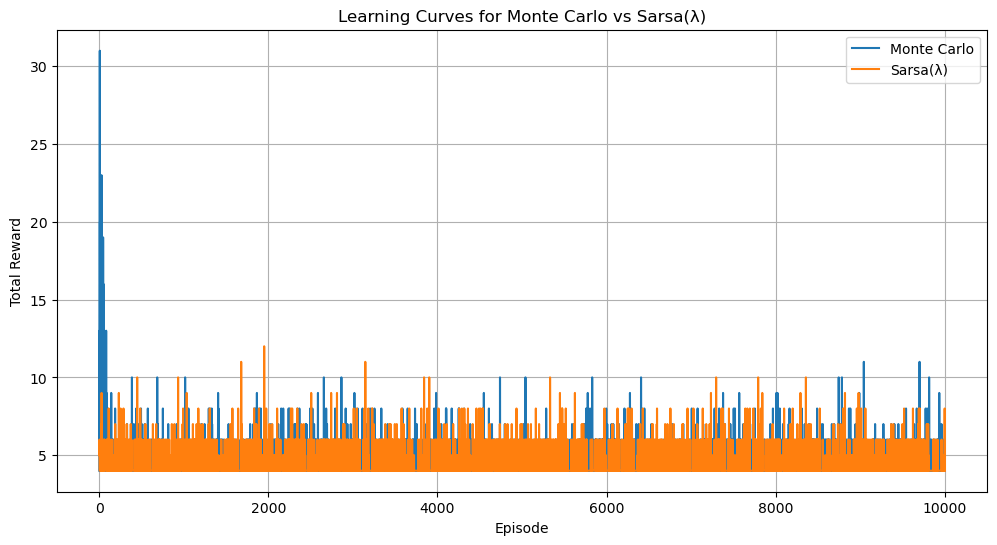

In [71]:
def plot_learning_curves(rewards_mc, rewards_sarsa):
    episodes = np.arange(1, len(rewards_mc) + 1)
    plt.figure(figsize=(12, 6))
    plt.plot(episodes, rewards_mc, label='Monte Carlo')
    plt.plot(episodes, rewards_sarsa, label='Sarsa(λ)')
    plt.xlabel('Episode')
    plt.ylabel('Total Reward')
    plt.title('Learning Curves for Monte Carlo vs Sarsa(λ)')
    plt.legend()
    plt.grid(True)
    plt.show()

plot_learning_curves(rewards_mc, rewards_sarsa)

In [22]:
from sklearn.utils import resample

def bootstrap_resample(rewards, n_iterations=1000, confidence_level=0.95):
    """ Resample the rewards array and compute confidence intervals """
    mean_rewards = []
    for _ in range(n_iterations):
        # calculate mean
        sample_rewards = resample(rewards)
        mean_rewards.append(np.mean(sample_rewards))
    
    # Compute percentiles for confidence intervals
    lower_bound = np.percentile(mean_rewards, (1 - confidence_level) / 2 * 100)
    upper_bound = np.percentile(mean_rewards, (1 + confidence_level) / 2 * 100)
    return np.mean(mean_rewards), lower_bound, upper_bound


mean_reward, lower_ci, upper_ci = bootstrap_resample(rewards_mc)
print(f"Mean Reward: {mean_reward}, CI: [{lower_ci}, {upper_ci}]")


Mean Reward: 4.280112083, CI: [4.2786155500000005, 4.281604025]


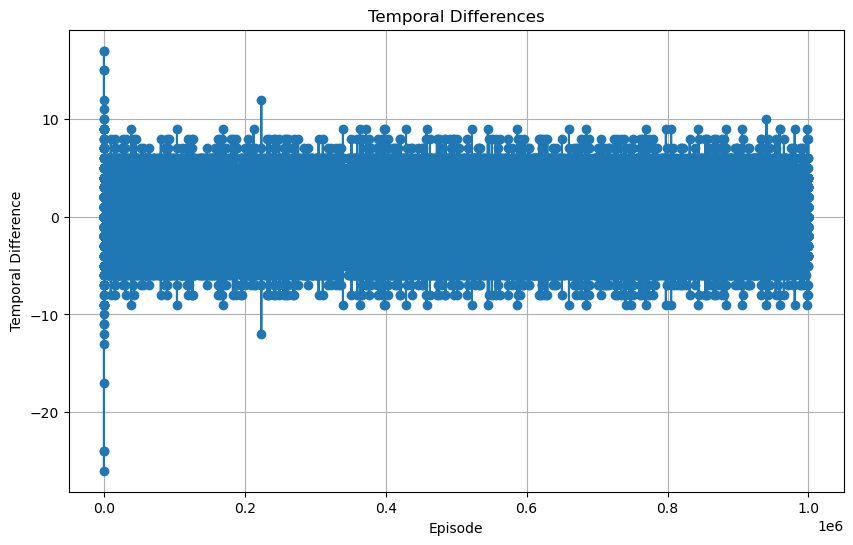

In [27]:
def plot_temporal_differences(rewards, title='Temporal Differences'):
    """ Plot the difference between expected and actual rewards over time """
    deltas = [j-i for i, j in zip(rewards[:-1], rewards[1:])]
    
    plt.figure(figsize=(10, 6))
    plt.plot(range(len(deltas)), deltas, marker='o')
    plt.title(title)
    plt.xlabel('Episode')
    plt.ylabel('Temporal Difference')
    plt.grid(True)
    plt.show()


plot_temporal_differences(rewards_sarsa)


In [53]:
def initialize_environment(height, width, pipe_gap):
    env = gym.make('TextFlappyBird-v0', height=height, width=width, pipe_gap=pipe_gap)
    return env


env_config1 = initialize_environment(15, 20, 4)
env_config2 = initialize_environment(18, 24, 6)


In [57]:
import numpy as np
from collections import defaultdict
import gymnasium as gym
import json



# SARSA(λ) implementation with eligibility traces
def sarsa_lambda_with_traces(env, num_episodes, alpha, epsilon, min_epsilon, epsilon_decay, discount_factor, lambda_):
    Q = defaultdict(lambda: np.zeros(env.action_space.n))
    E = defaultdict(float)  # Eligibility traces
    rewards_sarsa = []

    for i_episode in range(num_episodes):
        total_reward = 0
        state = env.reset()
        state = serialize(state)
        action_probs = make_epsilon_greedy_policy(Q, epsilon, env.action_space.n)(state)
        action = np.random.choice(np.arange(len(action_probs)), p=action_probs)

        while True:
            next_state, reward, done, truncated, _ = env.step(action)
            next_state = serialize(next_state)
            next_action_probs = make_epsilon_greedy_policy(Q, epsilon, env.action_space.n)(next_state)
            next_action = np.random.choice(np.arange(len(next_action_probs)), p=next_action_probs)

            delta = reward + discount_factor * Q[next_state][next_action] - Q[state][action]
            E[state] += 1  # Increment eligibility for visited state-action pair

            for s in Q:
                for a in range(len(Q[s])):
                    Q[s][a] += alpha * delta * E[s]
                    E[s] *= discount_factor * lambda_  # Decay eligibility traces

            if done:
                break
            state = next_state
            action = next_action
            total_reward += reward

        rewards_sarsa.append(total_reward)
        # Epsilon decay
        epsilon = max(min_epsilon, epsilon * epsilon_decay)

    return Q, rewards_sarsa


env = initialize_environment(15, 20, 4)
params = {
    'alpha': 0.5,
    'epsilon': 0.1,
    'min_epsilon': 0.1,
    'epsilon_decay': 0.995,
    'discount_factor': 0.9,
    'lambda_': 0.9
}
Q, rewards = sarsa_lambda_with_traces(env, 1000000, **params)


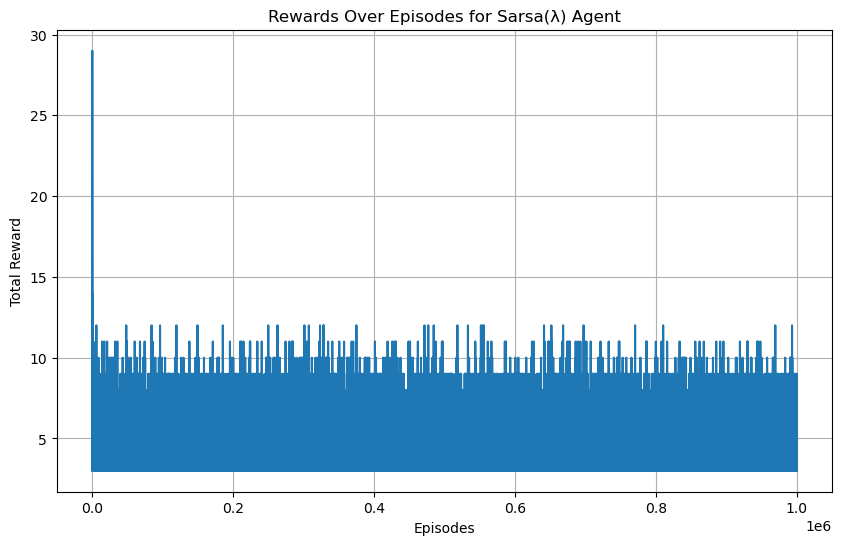

In [58]:
import matplotlib.pyplot as plt


def plot_rewards(rewards_sarsa, title='Rewards Over Episodes'):
    plt.figure(figsize=(10, 6))
    plt.plot(rewards_sarsa)
    plt.title(title)
    plt.xlabel('Episodes')
    plt.ylabel('Total Reward')
    plt.grid(True)
    plt.show()


plot_rewards(rewards, 'Rewards Over Episodes for Sarsa(λ) Agent')
